Further information can be obtained on [Wharton's website](https://wrds-www.wharton.upenn.edu/pages/support/manuals-and-overviews/compustat/capital-iq/transcripts/wrds-overview-capitaliq-transcripts-data/#general-description).

In [24]:
import wrds
import logging
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from dataclasses import dataclass
from typing import Optional
from pathlib import Path


nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
logging.basicConfig(level=logging.INFO, force=True)

In [26]:
db: wrds.Connection = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


Run the query
Using our WRDS connection, db, we can run a query with some joins and filters.This query retrieves transcript component text as well as transcript and speaker metadata.

Three tables are used:

- wrds_transcript_detail - transcript metadata
- wrds_transcript_person - speaker metadata
- ciqtranscriptcomponent - full transcript text
The transcript data is filtered to companies with CIQ CompanyId.

In [27]:
select_companies_with_id = '''
        SELECT DISTINCT d.companyid, d.companyname
        FROM ciq.wrds_transcript_detail as d
        WHERE date_part('year', mostimportantdateutc) BETWEEN 2023 AND 2024
'''

companies: pd.DataFrame = db.raw_sql(select_companies_with_id)

companies.companyid = companies.companyid.astype(int)

companies.head()

,companyid,companyname
0,18511,3i Group plc
1,18527,ABB Ltd
2,18671,Albemarle Corporation
3,18711,The Allstate Corporation
4,18749,"Amazon.com, Inc."


In [5]:
companies.dtypes

companyid               int64
companyname    string[python]
dtype: object

In [28]:
companies.to_csv(Path("..") / "data" / "companies.csv", sep="\t", index=False)

In [29]:
def get_companies(name: str) -> pd.DataFrame:
    """Filter function for search in companies dataframe
    I don't want to reach out to Wharton API with every and each search,
    so this function will filter in the pulled dataframe (companies)

    Args:
        name (str): Company name filter

    Returns:
        pd.DataFrame: list of companies with their id-s
    """

    return companies[companies.companyname.str.contains(name, case=False, na=False)]

In [30]:
def get_company_id(company: str) -> int | None:
    """Filtering based on company name and returning the one and only company's id

    Args:
        company (str): Company name, expected full match

    Returns:
        int: returned id, None if there's no such company
    """
    filtered: pd.DataFrame = companies[companies.companyname.str.fullmatch(company)]
    return filtered.companyid.item() if filtered.shape[0] == 1 else None

In [31]:
def get_company_names(ids: list[str]) -> pd.DataFrame:
    """Filter function for search in companies dataframe based on id
    I don't want to reach out to Wharton API with every and each search,
    so this function will filter in the pulled dataframe (companies)

    Args:
        ids (list[str]): Company id filter, all matching companies are returned

    Returns:
        pd.DataFrame: list of companies with their id-s
    """

    return companies[companies.companyname.isin(ids)]

In [32]:
company_name = 'goog'

filtered = get_companies(company_name)
filtered

,companyid,companyname
8897,312932093,Google LLC


In [33]:
goog: str = 'Google LLC'

google_id = get_company_id(goog)
google_id

312932093

In [16]:
chipotle = 'Chipotle Mexican Grill, Inc.'
chipotle_id = get_company_id(chipotle)

chipotle_id

26446

In [17]:
asml = 'ASML Holding N.V.'
asml_id = get_company_id(asml)

asml_id

388904

In [34]:
def get_id_string(ids: list[str]):
    company_id_string: str = ""
    for c in ids:
        company_id_string += str(c) + ','

    return company_id_string[:-1]

In [35]:
company_id_list: list = [google_id, chipotle_id, asml_id]

company_id_string = get_id_string(company_id_list)
company_id_string

NameError: name 'chipotle_id' is not defined

In [45]:
sql_query = f'''
            SELECT a.*, b.*, c.componenttext
            FROM (
                  SELECT * 
                  FROM ciq.wrds_transcript_detail
                  WHERE companyid IN ({google_id})
                    AND date_part('year', mostimportantdateutc) BETWEEN 2000 AND 2025
                 ) AS a
            JOIN ciq.wrds_transcript_person AS b
              ON a.transcriptid = b.transcriptid
            JOIN ciq.ciqtranscriptcomponent AS c
              ON b.transcriptcomponentid = c.transcriptcomponentid
            ORDER BY a.transcriptid, b.componentorder;
            '''

df = db.raw_sql(sql_query)

In [46]:
df.head()

,companyid,keydevid,transcriptid,headline,mostimportantdateutc,mostimportanttimeutc,keydeveventtypeid,keydeveventtypename,companyname,transcriptcollectiontypeid,...,transcriptcomponenttypename,transcriptpersonid,transcriptpersonname,proid,companyofperson,speakertypeid,speakertypename,componenttextpreview,word_count,componenttext
0,312932093.0,559468849.0,1462178.0,Google LLC Presents at The 14th annual Red Hat...,2018-05-10,15:30:00,51.0,Company Conference Presentations,Google LLC,7,...,Presenter Speech,359364.0,Chris Wright,<NA>,<NA>,5,Attendees,Now if there's a company that understands thes...,88,Now if there's a company that understands thes...
1,312932093.0,559468849.0,1462178.0,Google LLC Presents at The 14th annual Red Hat...,2018-05-10,15:30:00,51.0,Company Conference Presentations,Google LLC,7,...,Answer,359364.0,Chris Wright,<NA>,<NA>,5,Attendees,All right. Most of you know Kohl's as a chain ...,44,All right. Most of you know Kohl's as a chain ...
2,312932093.0,559468849.0,1462178.0,Google LLC Presents at The 14th annual Red Hat...,2018-05-10,15:30:00,51.0,Company Conference Presentations,Google LLC,7,...,Answer,359365.0,Ritch Houdek,<NA>,<NA>,5,Attendees,"Sure thing. So first of all, it's great to be ...",214,"Sure thing. So first of all, it's great to be ..."
3,312932093.0,559468849.0,1462178.0,Google LLC Presents at The 14th annual Red Hat...,2018-05-10,15:30:00,51.0,Company Conference Presentations,Google LLC,7,...,Answer,359363.0,Cassie Kozyrkov,<NA>,<NA>,2,Executives,So we at Google are thrilled to be in this jou...,29,So we at Google are thrilled to be in this jou...
4,312932093.0,559468849.0,1462178.0,Google LLC Presents at The 14th annual Red Hat...,2018-05-10,15:30:00,51.0,Company Conference Presentations,Google LLC,7,...,Answer,359365.0,Ritch Houdek,<NA>,<NA>,5,Attendees,Yes. So as we embarked on our hybrid cloud jou...,238,Yes. So as we embarked on our hybrid cloud jou...


In [47]:
df = df.drop(['transcriptpersonname'], axis=1)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   companyid                       150 non-null    Float64
 1   keydevid                        150 non-null    Float64
 2   transcriptid                    150 non-null    Float64
 3   headline                        150 non-null    string 
 4   mostimportantdateutc            150 non-null    string 
 5   mostimportanttimeutc            150 non-null    string 
 6   keydeveventtypeid               150 non-null    Float64
 7   keydeveventtypename             150 non-null    string 
 8   companyname                     150 non-null    string 
 9   transcriptcollectiontypeid      150 non-null    Int64  
 10  transcriptcollectiontypename    150 non-null    string 
 11  transcriptpresentationtypeid    150 non-null    Int64  
 12  transcriptpresentationtypename  150 

In [49]:
transcripts: pd.DataFrame = (
    df.groupby(["companyid", "mostimportantdateutc", "mostimportanttimeutc", "headline"])
    .apply(
        lambda group: "\n".join(
            f"{row['speakertypename']}: {row['componenttext']}" for _, row in group.iterrows()
        ),
        include_groups=False,
    )
    .reset_index(name="full_text")
)

In [50]:
transcripts.companyid = transcripts.companyid.astype(int)
transcripts.head()

,companyid,mostimportantdateutc,mostimportanttimeutc,headline,full_text
0,312932093,2018-05-10,15:30:00,Google LLC Presents at The 14th annual Red Hat...,Attendees: Now if there's a company that under...
1,312932093,2023-06-15,21:00:00,"Google LLC, Squarespace, Inc. - M&A Call","Operator: Good afternoon. My name is Sara, and..."


In [51]:
transcripts['word_count'] = transcripts['full_text'].apply(lambda x: len(str(x).split()))

In [52]:
transcripts['word_count_nltk'] = transcripts['full_text'].apply(
    lambda x: len(word_tokenize(str(x)))
)

In [53]:
grouped_transcripts = transcripts.groupby('companyid')

for company_id, group in grouped_transcripts:
    group.to_csv(
        Path("..") / "data" / f"{company_id}.csv",
        sep='\t',
        index=False,
        quoting=1,
        escapechar='\\',
        doublequote=True,
        quotechar='"',
        lineterminator='\n',
    )

In [54]:
df_google = pd.read_csv(
    Path("..") / "data" / f"{google_id}.csv",
    sep='\t',
    quoting=1,
    escapechar='\\',
    doublequote=True,
    quotechar='"',
)

df_google.head()

,companyid,mostimportantdateutc,mostimportanttimeutc,headline,full_text,word_count,word_count_nltk
0,312932093,2018-05-10,15:30:00,Google LLC Presents at The 14th annual Red Hat...,Attendees: Now if there's a company that under...,12407,14475
1,312932093,2023-06-15,21:00:00,"Google LLC, Squarespace, Inc. - M&A Call","Operator: Good afternoon. My name is Sara, and...",10078,11800


In [55]:
df_google

,companyid,mostimportantdateutc,mostimportanttimeutc,headline,full_text,word_count,word_count_nltk
0,312932093,2018-05-10,15:30:00,Google LLC Presents at The 14th annual Red Hat...,Attendees: Now if there's a company that under...,12407,14475
1,312932093,2023-06-15,21:00:00,"Google LLC, Squarespace, Inc. - M&A Call","Operator: Good afternoon. My name is Sara, and...",10078,11800


In [13]:
import logging


@dataclass
class WhartonCompanyIdSearchCache:
    id: int
    name: str
    df: pd.DataFrame
    transcripts: Optional[pd.DataFrame]


class WhartonScraper:
    """
    Wrapper Class for Scraping Wharton Transcripts database for a single company
    Based on Company name or id.
    """

    def __init__(
        self,
        connection: wrds.Connection,
    ):
        self.connection: wrds.Connection = connection
        self.company_search_cache: WhartonCompanyIdSearchCache = None

    def __repr__(self):
        return f"WhartonScraper(id={self.company_search_cache.id}, name={self.company_search_cache.name})"

    def __str__(self):
        return f"WhartonScraper for company ({self.company_search_cache.name})"

    def pipeline(self, company_id: str) -> None:
        """Full Pipeline for transcript acquisition from Wharton database, based on `companyid`

        Args:
            company_id (str): `companyid` to filter by
        """
        self.get_company_by_id(company_id)
        self.get_company_transcripts()
        self.transcripts_to_csv()

    def get_company_by_id(self, company_id: str) -> Optional[pd.DataFrame]:
        """
        Reaching out to Wharton database to see if `companyid` is present
        """
        if self.company_search_cache and self.company_search_cache.id == company_id:
            logging.debug(f"using cache on company: {company_id}")
            return self.company_search_cache.df

        select_company = f"""
            SELECT DISTINCT d.companyid, d.companyname
            FROM ciq.wrds_transcript_detail as d
            WHERE d.companyid = {company_id}
        """
        df: pd.DataFrame = self.connection.raw_sql(select_company)

        if df.shape[0] > 1:
            logging.debug(f"too many results for search: {df.shape[0]}")
            self.company_search_cache = None
            return None

        self.company_search_cache = WhartonCompanyIdSearchCache(
            id=company_id, name=df.companyname[0], df=df, transcripts=None
        )
        logging.info(f"information acquired for company: {company_id}")
        return df

    def get_company_transcripts(self) -> Optional[pd.DataFrame]:
        """
        Acquiring company transcripts based on the cached `companyid`
        """
        if not self.company_search_cache:
            logging.debug("no company cache")
            return None
        if self.company_search_cache.transcripts:
            logging.debug("transcripts already cached")
            return self.company_search_cache.transcripts

        query = f"""
            SELECT a.*, b.*, c.componenttext
            FROM (
                  SELECT * 
                  FROM ciq.wrds_transcript_detail
                  WHERE companyid = {self.company_search_cache.id}
                    AND date_part('year', mostimportantdateutc) BETWEEN 2023 AND 2025
                 ) AS a
            JOIN ciq.wrds_transcript_person AS b
              ON a.transcriptid = b.transcriptid
            JOIN ciq.ciqtranscriptcomponent AS c
              ON b.transcriptcomponentid = c.transcriptcomponentid
            ORDER BY a.transcriptid, b.componentorder;
            """
        df = self.connection.raw_sql(query)
        df = df.drop(["transcriptpersonname"], axis=1)
        transcripts: pd.DataFrame = (
            df.groupby(
                [
                    "companyid",
                    "mostimportantdateutc",
                    "mostimportanttimeutc",
                    "headline",
                ]
            )
            .apply(
                lambda group: "\n".join(
                    f"{row['speakertypename']}: {row['componenttext']}"
                    for _, row in group.iterrows()
                ),
                include_groups=False,
            )
            .reset_index(name="full_text")
        )
        transcripts.companyid = transcripts.companyid.astype(int)
        transcripts["word_count"] = transcripts["full_text"].apply(lambda x: len(str(x).split()))
        transcripts["word_count_nltk"] = transcripts["full_text"].apply(
            lambda x: len(word_tokenize(str(x)))
        )

        self.company_search_cache.transcripts = transcripts
        logging.info(
            f"transcripts acquired for company: {self.company_search_cache.id} with a shape: {transcripts.shape}"
        )
        return transcripts

    def transcripts_to_csv(self) -> None:
        """
        Writing transcript dataset to file if it is present
        """
        if self.company_search_cache.transcripts is None:
            logging.debug("no transcript records.")
            return

        self.company_search_cache.transcripts.to_csv(
            Path("..") / "data" / f"{self.company_search_cache.id}.csv",
            sep="\t",
            index=False,
            quoting=1,
            escapechar="\\",
            doublequote=True,
            quotechar='"',
            lineterminator="\n",
        )
        logging.info(f"transcripts successfully written to {self.company_search_cache.id}.csv")

In [14]:
scraper = WhartonScraper(connection=db)

df = scraper.get_company_by_id(google_id)
scraper

OperationalError: (psycopg2.OperationalError) server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.
server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.

[SQL: 
            SELECT DISTINCT d.companyid, d.companyname
            FROM ciq.wrds_transcript_detail as d
            WHERE d.companyid = 312932093
        ]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [15]:
scraper.pipeline('31293209')
scraper

PendingRollbackError: Can't reconnect until invalid transaction is rolled back.  Please rollback() fully before proceeding (Background on this error at: https://sqlalche.me/e/20/8s2b)

In [63]:
stop_words = stopwords.words('english')
stop_words

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [70]:
import re
from collections import Counter
import matplotlib.pyplot as plt


class WordCounter:
    def __init__(self, text: str, stop_words=None):
        self.text = text
        self.stop_words = set(stop_words) if stop_words else None
        self.word_counts = self._count_words()

    def _count_words(self):
        words = re.findall(r"\b\w+\b", self.text.lower())
        if self.stop_words:
            words = [word for word in words if word in self.stop_words]
        return Counter(words).most_common(36)

    def get_count(self, word: str) -> int:
        return self.word_counts.get(word.lower(), 0)

    def get_all_counts(self) -> dict:
        return dict(self.word_counts)

    def plot_counts(self):
        words, counts = zip(*self.word_counts)
        plt.figure(figsize=(10, 5))
        plt.bar(words, counts, color='skyblue')
        plt.xlabel("Words")
        plt.ylabel("Count")
        plt.title("Word Frequency")
        plt.xticks(rotation=45)
        plt.show()

In [71]:
example_text = scraper.company_search_cache.transcripts.full_text[0]

len(example_text)

53785

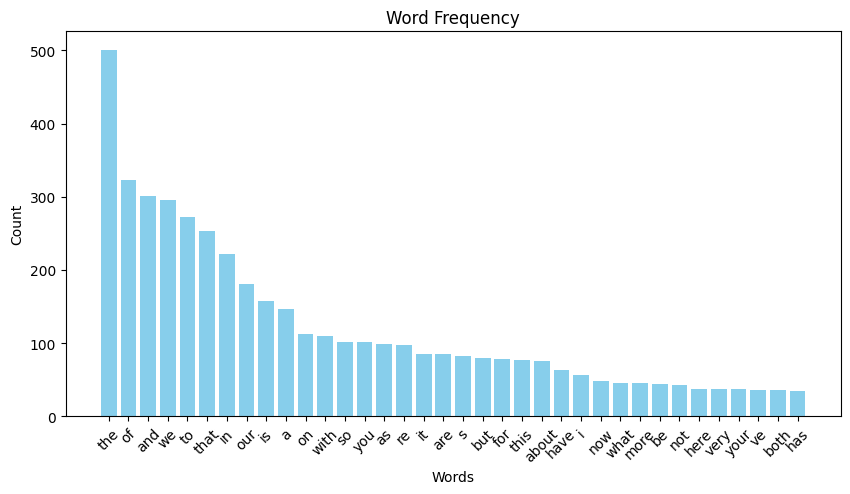

In [72]:
counter = WordCounter(example_text, stop_words=stop_words)

counter.plot_counts()

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
lower_text = example_text.lower()

words = word_tokenize(lower_text)

words = [word for word in words if word.isalnum()]

stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word not in stop_words]

print(f'original: {len(words)}, filtered: {len(filtered_words)}')

original: 9456, filtered: 4498


In [98]:
len(example_text.split())

9541

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import evaluate

filtered_text = " ".join(filtered_words)

model_name = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [96]:
len(filtered_words)

4498

In [91]:
source_word_count = len(filtered_words)
target_min = int(source_word_count * 0.10)
target_max = int(source_word_count * 0.30)

inputs = tokenizer(filtered_text, return_tensors="pt", truncation=True, max_length=1024)

summary_ids = model.generate(
    inputs["input_ids"],
    num_beams=4,
    max_length=target_max,
    min_length=target_min,
    early_stopping=True,
)

summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

{'input_ids': tensor([[    0, 31111,  5019,  ...,   843,   434,     2]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])}


In [92]:
summary

'analysts right go ahead get started good morning happy new year welcome jpmorgan 21st annual technology automotive investor forum consumer electronics show name harlan sur semiconductor semiconductor capital equipment analyst firm pleased introduce colette kress executive vice president chief financial officer n Nvidia tradition 9 years n Nvidia team specifically colette first present investor conference team driving many trends going hear today right artificial intelligence compute acceleration compute platforms automotive gaming iot addition nvidia team driving emerging software services revenue stream asked colette start us overview team announced tuesday ces special address go ahead kick q colette thank 9 years support turn executives thank really pleased would miss even great weather experiencing would miss come need make opening reminder statement presentation discussions contains statements investors advised read reports filed sec information relates risks uncertainties facing 

In [93]:
def compression_ratio(summary, source):
    summary_word_count = len(summary.split())
    source_word_count = len(source.split())
    return summary_word_count / source_word_count


ratio = compression_ratio(summary, filtered_text)
print(f"\nCompression Ratio related to filted text: {ratio:.2%}")
ratio = compression_ratio(summary, example_text)
print(f"\nCompression Ratio related to original text: {ratio:.2%}")


Compression Ratio related to filted text: 12.74%

Compression Ratio related to original text: 6.01%


In [ ]:
rouge = evaluate.load("rouge")

rouge_scores = rouge.compute(predictions=[summary], references=[example_text])

print("\nROUGE Scores:")
for key, value in rouge_scores.items():
    print(f"{key}: {value:.4f}")

INFO:absl:Using default tokenizer.



ROUGE Scores:
rouge1: 0.1093
rouge2: 0.0423
rougeL: 0.1085
rougeLsum: 0.1087


In [ ]:
rouge_scores = rouge.compute(predictions=[summary], references=[filtered_text])

print("\nROUGE Scores:")
for key, value in rouge_scores.items():
    print(f"{key}: {value:.4f}")

INFO:absl:Using default tokenizer.



ROUGE Scores:
rouge1: 0.2248
rouge2: 0.2221
rougeL: 0.2240
rougeLsum: 0.2240
